In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_3821438/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "dxDAO - xDXdao"
SPLITS_FREQ = "W-THU"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-05-05"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2356 non-null   object        
 1   author             2356 non-null   object        
 2   date               2356 non-null   datetime64[us]
 3   start              2356 non-null   datetime64[us]
 4   end                2323 non-null   datetime64[us]
 5   platform_proposal  2356 non-null   object        
dtypes: datetime64[us](3), object(3)
memory usage: 110.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8479 entries, 0 to 8478
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        8479 non-null   object        
 1   proposal  8479 non-null   object        
 2   voter     8479 non-null   object        
 3   date      8479 non-null   datetime64[us]
dtypes

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/baseline/folds-info_W-THU_normalize.parquet
fold
2023-02-02    8410
2023-02-09    8424
2023-02-16    8429
2023-02-23    8431
2023-03-02    8433
2023-03-09    8435
2023-03-16    8437
2023-03-23    8439
2023-03-30    8441
2023-04-06    8441
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W05,13,9,6,0.69,1.50,11,6,0.85,1.83
2023-W06,13,13,7,1.00,1.86,5,4,0.38,1.25
2023-W07,5,5,4,1.00,1.25,1,1,0.20,1.00
2023-W08,7,4,2,0.57,2.00,3,2,0.43,1.50
2023-W09,5,3,2,0.60,1.50,2,1,0.40,2.00
2023-W10,7,3,2,0.43,1.50,4,1,0.57,4.00
2023-W11,5,2,1,0.40,2.00,3,1,0.60,3.00
2023-W12,2,1,1,0.50,1.00,1,1,0.50,1.00
2023-W13,2,2,2,1.00,1.00,0,0,0.00,nan


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W05 & 13 & 9 & 6 & 0.69 & 1.50 & 11 & 6 & 0.85 & 1.83 \\
2023-W06 & 13 & 13 & 7 & 1.00 & 1.86 & 5 & 4 & 0.38 & 1.25 \\
2023-W07 & 5 & 5 & 4 & 1.00 & 1.25 & 1 & 1 & 0.20 & 1.00 \\
2023-W08 & 7 & 4 & 2 & 0.57 & 2.00 & 3 & 2 & 0.43 & 1.50 \\
2023-W09 & 5 & 3 & 2 & 0.60 & 1.50 & 2 & 1 & 0.40 & 2.00 \\
2023-W10 & 7 & 3 & 2 & 0.43 & 1.50 & 4 & 1 & 0.57 & 4.00 \\
2023-W11 & 5 & 2 & 1 & 0.40 & 2.00 & 3 & 1 & 0.60 & 3.00 \\
2023-W12 & 2 & 1 & 1 & 0.50 & 1.00 & 1 & 1 & 0.50 & 1.00 \\
2023-W13 & 2 & 2 & 2 & 1.00 & 1.00 & 0 & 0 & 0.00 & nan \\
2023-W14 & 3 & 1 & 1 & 0.33 & 1.00 & 37 & 31 & 12.33 & 1.19 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        if ok_in_a_row > max_ok_in_a_row[0]:
            max_ok_in_a_row = (ok_in_a_row, t)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/195 [00:00<?, ?it/s]

Warning, empty test fold 12 (2019-10-10 00:00:00), all ok since 12 folds ago
Warning, empty test fold 13 (2019-10-17 00:00:00), all ok since 1 folds ago


Warning, test fold 14 (2019-10-24 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 15 (2019-10-31 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 16 (2019-11-07 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago
Warning, test fold 17 (2019-11-14 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 19 (2019-11-28 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, test fold 20 (2019-12-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 22 (2019-12-19 00:00:00), all ok since 9 folds ago
Warning, empty test fold 23 (2019-12-26 00:00:00), all ok since 1 folds ago


Warning, empty test fold 24 (2020-01-02 00:00:00), all ok since 1 folds ago
Warning, test fold 25 (2020-01-09 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 26 (2020-01-16 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 27 (2020-01-23 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 28 (2020-01-30 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 30 (2020-02-13 00:00:00) with less than 5 open proposals (2). all ok since 2 folds ago


Warning, empty test fold 31 (2020-02-20 00:00:00), all ok since 7 folds ago
Warning, test fold 32 (2020-02-27 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 33 (2020-03-05 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, test fold 34 (2020-03-12 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 65 (2020-10-15 00:00:00), all ok since 34 folds ago


Warning, test fold 192 (2023-03-23 00:00:00) with less than 5 open proposals (2). all ok since 127 folds ago
Warning, empty test fold 193 (2023-03-30 00:00:00), all ok since 128 folds ago


Warning, test fold 194 (2023-04-06 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Max ok in a row: (128, Timestamp('2023-03-30 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/baseline/openpop_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,189.000000,185.000000,181.000000,180.000000,180.000000,195.000000
mean,0.189020,0.165638,0.149192,0.102285,0.075039,0.011577,0.188820,0.223657,0.253875,0.284194,...,0.389892,0.418613,0.427044,0.245523,0.343152,0.391091,0.417841,0.420935,0.421066,0.115957
std,0.251729,0.171482,0.144781,0.098684,0.078192,0.012588,0.251738,0.246859,0.263369,0.268236,...,0.343003,0.346842,0.350870,0.301537,0.297674,0.298698,0.296415,0.296401,0.296487,0.018335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068444
25%,0.000000,0.027778,0.037981,0.029670,0.024026,0.003604,0.000000,0.025111,0.043098,0.068279,...,0.093990,0.127706,0.130911,0.000000,0.125000,0.194444,0.200000,0.200000,0.200000,0.115756
50%,0.111111,0.111111,0.116667,0.094118,0.066667,0.010000,0.111111,0.135303,0.163604,0.208793,...,0.304902,0.357143,0.365000,0.142857,0.305556,0.375000,0.400000,0.400000,0.400000,0.124146
75%,0.250000,0.272222,0.200000,0.140000,0.100000,0.015000,0.250000,0.335381,0.390014,0.427419,...,0.574435,0.636905,0.668056,0.354167,0.481481,0.527778,0.600000,0.600852,0.604167,0.127085
max,1.000000,1.000000,0.800000,0.640000,0.666667,0.114000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.133231


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/dxDAO - xDXdao/baseline/perfect_W-THU_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.958974,0.613978,0.445661,0.251720,0.170138,0.025562,0.958974,0.958974,0.958974,0.958974,...,0.956174,0.958736,0.958974,0.602017,0.856056,0.922873,0.956174,0.958736,0.958974,0.127112
std,0.198860,0.210735,0.186042,0.130487,0.093616,0.014215,0.198860,0.198860,0.198860,0.198860,...,0.198766,0.198822,0.198860,0.230635,0.207207,0.200743,0.198766,0.198822,0.198860,0.016996
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071560
25%,1.000000,0.500000,0.323636,0.161818,0.107879,0.016182,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.474058,0.822240,0.938301,1.000000,1.000000,1.000000,0.127438
50%,1.000000,0.636364,0.440000,0.240000,0.160000,0.024000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.607143,0.907143,0.990196,1.000000,1.000000,1.000000,0.128761
75%,1.000000,0.750000,0.575000,0.321429,0.218333,0.032750,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,0.129926
max,1.000000,1.000000,1.000000,0.900000,0.733333,0.114000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.302183


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,195,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,189.000000,185.000000,181.000000,180.000000,180.000000,195.000000,0.0,0.0
mean,2021-05-27 00:00:00,0.189020,0.165638,0.149192,0.102285,0.075039,0.011577,0.188820,0.223657,0.253875,...,0.427044,0.245523,0.343152,0.391091,0.417841,0.420935,0.421066,0.115957,NaN,NaN
min,2019-07-18 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068444,NaN,NaN
25%,2020-06-21 12:00:00,0.000000,0.027778,0.037981,0.029670,0.024026,0.003604,0.000000,0.025111,0.043098,...,0.130911,0.000000,0.125000,0.194444,0.200000,0.200000,0.200000,0.115756,NaN,NaN
50%,2021-05-27 00:00:00,0.111111,0.111111,0.116667,0.094118,0.066667,0.010000,0.111111,0.135303,0.163604,...,0.365000,0.142857,0.305556,0.375000,0.400000,0.400000,0.400000,0.124146,NaN,NaN
75%,2022-05-01 12:00:00,0.250000,0.272222,0.200000,0.140000,0.100000,0.015000,0.250000,0.335381,0.390014,...,0.668056,0.354167,0.481481,0.527778,0.600000,0.600852,0.604167,0.127085,NaN,NaN
max,2023-04-06 00:00:00,1.000000,1.000000,0.800000,0.640000,0.666667,0.114000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.133231,NaN,NaN
std,NaN,0.251729,0.171482,0.144781,0.098684,0.078192,0.012588,0.251738,0.246859,0.263369,...,0.350870,0.301537,0.297674,0.298698,0.296415,0.296401,0.296487,0.018335,NaN,NaN


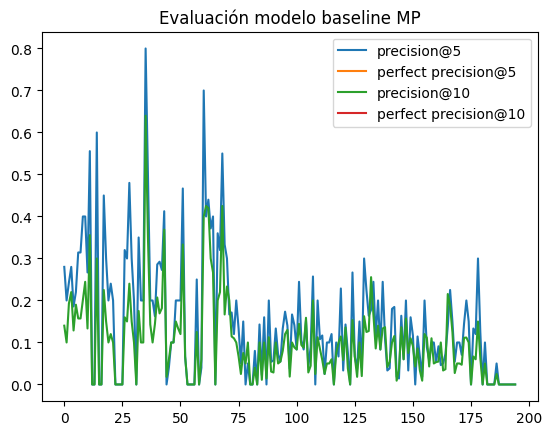

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,...,10.000000,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-03-05 12:00:00,0.0,0.008333,0.005000,0.002500,0.001667,0.000250,0.0,0.009671,0.009671,...,0.012500,0.0,0.050000,0.050000,0.050000,0.050000,0.050000,0.082205,NaN,NaN
min,2023-02-02 00:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.069689,NaN,NaN
25%,2023-02-17 18:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.073242,NaN,NaN
50%,2023-03-05 12:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.081513,NaN,NaN
75%,2023-03-21 06:00:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.082770,NaN,NaN
max,2023-04-06 00:00:00,0.0,0.083333,0.050000,0.025000,0.016667,0.002500,0.0,0.096713,0.096713,...,0.125000,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.118132,NaN,NaN
std,NaN,0.0,0.026352,0.015811,0.007906,0.005270,0.000791,0.0,0.030583,0.030583,...,0.039528,0.0,0.158114,0.158114,0.158114,0.158114,0.158114,0.013851,NaN,NaN
